In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape

In [2]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2
encoder_input = Input(shape = (28,28,1))
x = Conv2D(32, 3, activation = 'relu', strides=2, padding='same')(encoder_input)
x = Conv2D(64, 3, activation = 'relu', strides=2, padding='same')(x)
x = Flatten()(x)

x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_input, [z_mean, z_log_var, z], name = 'encoder')

In [4]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [5]:
latent_inputs = keras.Input(shape = (latent_dim,))
x = Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, decoder_output, name='decoder')

In [6]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data,reconstruction))
            
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        gradient = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradient, self.trainable_weights))
        
        return {
            "loss" : total_loss,
            "recon_loss" : reconstruction_loss,
            "kl_loss" : kl_loss
        }

In [8]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

In [9]:
import numpy as np

In [10]:
mnist = np.concatenate([x_train, x_test], axis = 0)

In [11]:
mnist_images = np.expand_dims(mnist, -1).astype('float32') / 255

In [12]:
mnist_images.shape

(70000, 28, 28, 1)

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='rmsprop')
vae.fit(mnist_images, epochs=100, batch_size=64)

Epoch 1/100
1094/1094 [==============================] - 26s 23ms/step - loss: 293.9704 - recon_loss: 289.3870 - kl_loss: 4.5833
Epoch 2/100
1094/1094 [==============================] - 25s 23ms/step - loss: 274.0354 - recon_loss: 269.8239 - kl_loss: 4.2116
Epoch 3/100
1094/1094 [==============================] - 26s 23ms/step - loss: 269.3640 - recon_loss: 265.4305 - kl_loss: 3.9334
Epoch 4/100
1094/1094 [==============================] - 25s 23ms/step - loss: 266.6808 - recon_loss: 262.8809 - kl_loss: 3.7999
Epoch 5/100
1094/1094 [==============================] - 25s 23ms/step - loss: 264.7445 - recon_loss: 261.0019 - kl_loss: 3.7426
Epoch 6/100
1094/1094 [==============================] - 25s 23ms/step - loss: 263.3026 - recon_loss: 259.5845 - kl_loss: 3.7181
Epoch 7/100
1094/1094 [==============================] - 25s 23ms/step - loss: 262.2181 - recon_loss: 258.5062 - kl_loss: 3.7119
Epoch 8/100
1094/1094 [==============================] - 25s 23ms/step - loss: 261.2447 - recon_l

KeyboardInterrupt: 

In [18]:
import matplotlib.pyplot as plt

Original Images


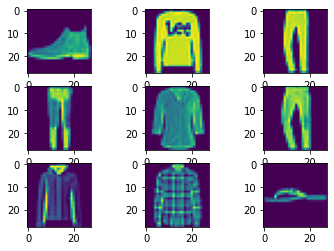

In [19]:
print("Original Images")

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_test[i])
plt.show()

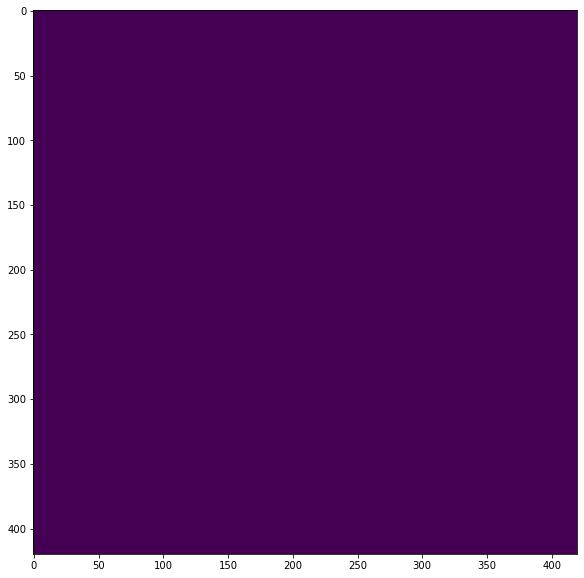

In [25]:
n = 15
img_size = 28

figure = np.zeros((n * img_size, n * img_size))

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_size, img_size)
        figure[i * img_size : (i + 1) * img_size,
               j * img_size : (j + 1) * img_size]
plt.figure(figsize=(10,10))
plt.imshow(figure)
plt.show()